# Identifying Trajectories with MAGIK


In [1]:
#!pip install deeplay  
# Uncomment if using Colab/Kaggle.

In [2]:
#!pip install gym opencv-python

## Exploring the Cell Tracking Data

Import the packages

In [1]:
import tracker
import stats
import visualizer
import utils


... and load the data ...

In [2]:

training_frames = utils.loadVideo("comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4", as_gray=True)
training_gt = utils.loadDataFrame("comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv")

training_gt = utils.dropDuplicates(training_gt)
training_gt = utils.interpolateTracks(training_gt)


... and predict locations from Trackpy.

In [3]:
training_detections = tracker.determineCentroids(training_frames)

Frame 266: 70 features


## Creating a Graph From Initial Dectections

Implement a class to obtain a graph from the trackpy detections ...

In [4]:
import numpy as np
import torch
from skimage import measure
from torch_geometric.data import Data

class GraphFromDetections:
    """Graph representation of the motion of cells."""

    def __init__(self, connectivity_radius, max_frame_distance):
        """Initialize graph."""
        self.connectivity_radius = connectivity_radius
        self.max_frame_distance = max_frame_distance

    #def get_node_attr(self, segmentation):
    #    """Compute node attributes."""
    #    labels = np.unique(segmentation)[1:]  # Labels without background
    #    node_attr = []
    #    for label in labels:
    #        mask = segmentation == label
    #        props = measure.regionprops(mask.astype(np.int32))[0]
    #        centroid = props.centroid / np.array(segmentation.shape)
    #        eccentricity = props.eccentricity
    #        node_attr.append([*centroid, eccentricity])
    #    return node_attr, labels

    def get_connectivity(self, node_attr, frames):
        """Compute connectivity."""
        xy = node_attr[:, :2]  # Extracted centroids
        distances = np.linalg.norm(xy[:, None] - xy, axis=-1)
        frame_diff = (frames[:, None] - frames) * -1
        mask = ((distances < self.connectivity_radius)
                & (frame_diff <= self.max_frame_distance) & (frame_diff > 0))
        edge_index, edge_attr = np.argwhere(mask), distances[mask]
        return edge_index, edge_attr

    def get_gt_connectivity(self, node_attr, frames, edge_index, ground_truth, epsilon=1.0):
        """Compute ground truth connectivity."""
        src_cell = edge_index[:, 0]
        tgt_cell = edge_index[:, 1]
        self_connections_mask = src_cell == tgt_cell
    
        src_xy = node_attr[src_cell, :2]
        tgt_xy = node_attr[tgt_cell, :2]
        src_frame = frames[src_cell]
        tgt_frame = frames[tgt_cell]
        
        # Mark ground truth connections
        relation_mask = np.zeros(len(edge_index), dtype=bool)

        for i, (s, t) in enumerate(zip(src_cell, tgt_cell)):

            # Find the closest cell in the ground truth to the src and tgt
            src_cell_gt = ground_truth.loc[
                (ground_truth["frame"] == src_frame[i])
                & (np.abs(ground_truth["x"] - src_xy[i, 0]) < epsilon)
                & (np.abs(ground_truth["y"] - src_xy[i, 1]) < epsilon)
            ]
            tgt_cell_gt = ground_truth.loc[
                (ground_truth["frame"] == tgt_frame[i])
                & (np.abs(ground_truth["x"] - tgt_xy[i, 0]) < epsilon)
                & (np.abs(ground_truth["y"] - tgt_xy[i, 1]) < epsilon)
            ]
            if src_cell_gt.empty or tgt_cell_gt.empty:
                continue
            
            if src_cell_gt["sperm"].values[0] == tgt_cell_gt["sperm"].values[0]:
                relation_mask[i] = True
    
        gt_connectivity = self_connections_mask | relation_mask
        return gt_connectivity

    def __call__(self, detections, ground_truth):
        """Compute graph by reading each row of the dataframe."""

        node_attr, node_labels, node_frames = [], [], []

        for index, row in detections.iterrows():
            node_frames.append(int(row["frame"]))
            node_attr.append([row["x"], row["y"], row["mass"], row["size"], row["ecc"] ])
            #node_labels.append(index)
        
        #node_attr = np.concatenate(node_attr)
        #node_labels = np.concatenate(node_labels)
        #frames = np.concatenate(frames)
    
        node_attr = np.array(node_attr)
        #node_labels = np.array(node_labels)
        node_frames = np.array(node_frames)

        edge_index, edge_attr = self.get_connectivity(node_attr, node_frames)
        edge_gt = self.get_gt_connectivity(node_attr, node_frames, edge_index, ground_truth)
    
        graph = Data(
            x=torch.tensor(node_attr, dtype=torch.float),
            edge_index=torch.tensor(edge_index.T, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr[:, None], dtype=torch.float),
            distance=torch.tensor(edge_attr[:, None], dtype=torch.float),
            frames=torch.tensor(node_frames, dtype=torch.float),
            y=torch.tensor(edge_gt[:, None], dtype=torch.float),
        )
        return graph

... instantiate it and construct the training graph ...

In [5]:
graph_constructor = GraphFromDetections(connectivity_radius=20.0,
                                           max_frame_distance=2)

train_graph = graph_constructor(training_detections,training_gt)

... verify the number of nodes and edges ...

In [6]:
print("Number of nodes:", len(train_graph.x))
print("Number of edges:", len(train_graph.edge_index[0]))

Number of nodes: 19741
Number of edges: 42783


... and plot the graph.

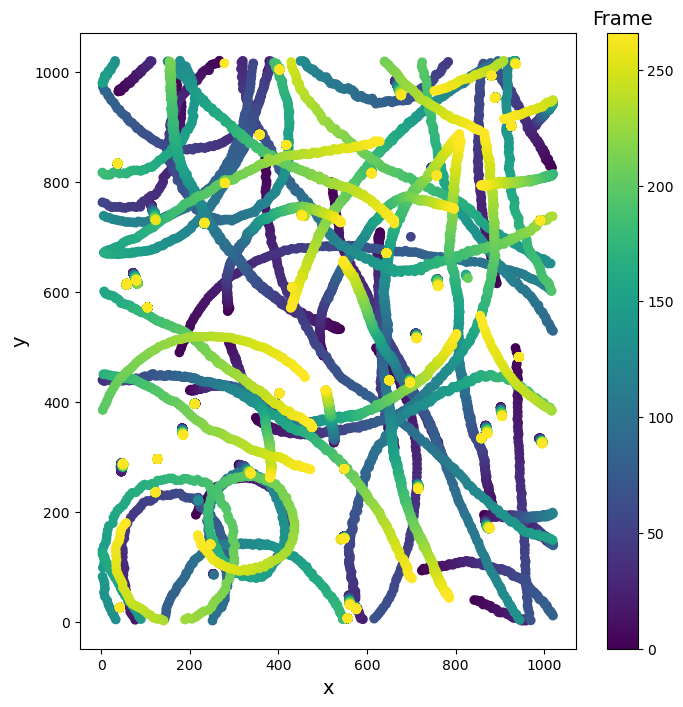

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i, j in train_graph.edge_index.T:
    plt.plot([train_graph.x[i, 1], train_graph.x[j, 1]],
             [train_graph.x[i, 0], train_graph.x[j, 0]], c="black", alpha=0.5)
plt.scatter(train_graph.x[:, 1], train_graph.x[:, 0],
            c=train_graph.frames, cmap="viridis", zorder=10)
cb = plt.colorbar()
cb.ax.set_title("Frame", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

## Building a Training Dataset

Implement a class to prepare the graph dataset ...

In [8]:
class CellTracingDataset(torch.utils.data.Dataset):
    """Class to prepare the graph dataset."""

    def __init__(self, graph, Dt, dataset_size, transform=None):
        """Initialize the graph dataset."""
        self.graph, self.Dt, self.dataset_size, self.transform = \
            graph, Dt, dataset_size, transform

    def __len__(self):
        """Obtain length of dataset."""
        return self.dataset_size

    def __getitem__(self, idx):
        """Return a graph from the dataset."""
        frames, edge_index = self.graph.frames, self.graph.edge_index
        select_frame = np.random.randint(self.Dt, frames.max() + 1)

        start_frame = select_frame - self.Dt
        node_mask = (frames >= start_frame) & (frames < select_frame)
        node_attr = self.graph.x[node_mask]

        frame_pairs = torch.stack([frames[edge_index[0, :]],
                                   frames[edge_index[1, :]]], axis=1)
        edge_mask = (frame_pairs >= start_frame) & (frame_pairs < select_frame)
        edge_mask = edge_mask.all(axis=1)
        edge_index = edge_index[:, edge_mask] - edge_index[:, edge_mask].min()

        graph = Data(
            x=node_attr,
            edge_index=edge_index,
            edge_attr=self.graph.edge_attr[edge_mask],
            distance=self.graph.edge_attr[edge_mask],
            y=self.graph.y[edge_mask],  # Ground truth edges.
        )
        if self.transform: graph = self.transform(graph)
        return graph

... implement some classes to define random rotation and random flip ...

In [9]:
from math import cos, pi, sin

class RandomRotation:
    """Random rotation."""

    def __call__(self, graph):
        """Perform the random rotation."""
        graph = graph.clone()
        node_attr = graph.x[:, :2] - 0.5  # Centered positions
        angle = np.random.rand() * 2 * pi
        R = torch.tensor([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])
        rotated_node_attr = torch.matmul(node_attr, R)
        graph.x[:, :2] = rotated_node_attr + 0.5  # Restored positions
        return graph

class RandomFlip:
    """Random flip."""

    def __call__(self, graph):
        """Perform the random flip."""
        graph = graph.clone()
        node_attr = graph.x[:, :2] - 0.5  # Centered positions
        if np.random.randint(2): node_attr[:, 0] *= -1
        if np.random.randint(2): node_attr[:, 1] *= -1
        graph.x[:, :2] = node_attr + 0.5  # Restored positions
        return graph

... create the training dataset ...

In [10]:
from torchvision.transforms import Compose

train_set = CellTracingDataset(
    train_graph, Dt=5, dataset_size=512,
    transform=Compose([RandomRotation(), RandomFlip()]),
)

... and define the data loaders.

In [11]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

## Making MAGIK

Define the MAGIK model ...

In [12]:
import deeplay as dl

model = dl.GraphToEdgeMAGIK([96,] * 4, 1, out_activation=torch.nn.Sigmoid)
model.encoder[0].configure(hidden_features=[32, 64], out_features=96,
                           out_activation=torch.nn.ReLU)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96,
                           out_activation=torch.nn.ReLU)
model.head.configure(hidden_features=[64, 32])

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=96, out_features=64, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=64, out_features=32, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=32, out_features=1, bias=True)
      (activation): Layer[Sigmoid]()
    )
  )
)

... print the model ...

In [13]:
print(model)

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=32, bias=True)
          (activation): Layer[ReLU]()
        )
        (1): LinearBlock(
          (layer): Layer[Linear](in_features=32, out_features=64, bias=True)
          (activation): Layer[ReLU]()
        )
        (2): LinearBlock(
          (layer): Layer[Linear](in_features=64, out_features=96, bias=True)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
     

... and train the MAGIK model.

In [14]:
classifier = dl.BinaryClassifier(model=model, optimizer=dl.Adam(lr=1e-3))
classifier = classifier.create()

trainer = dl.Trainer(max_epochs=10)
trainer.fit(classifier, train_loader)

/opt/miniconda3/envs/deeptrack/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/miniconda3/envs/deeptrack/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
W0523 10:17:46.095000 56494 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/opt/miniconda3/envs/deeptrack/lib/python3.11/site-packages/lightning/pytorch/utilities/mode

Epoch 9: 100%|██████████| 64/64 [00:31<00:00,  2.02it/s, v_num=1, train_loss_step=0.139, trainBinaryAccuracy_step=0.964, train_loss_epoch=0.177, trainBinaryAccuracy_epoch=0.945]


## Evaluating Performance

Load the test data ...

In [15]:
testing_frames = utils.loadVideo("comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4", as_gray=True)
testing_gt = utils.loadDataFrame("comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv")
testing_detections = tracker.determineCentroids(testing_frames)

Frame 263: 82 features


... construct the test graph ...

In [16]:
test_graph = graph_constructor(testing_detections,testing_gt)

... assess the model performance with the F1-score ...

In [17]:
from sklearn.metrics import f1_score

classifier.eval()
pred = classifier(test_graph)
predictions = pred.detach().numpy() > 0.5

ground_truth = test_graph.y

score = f1_score(ground_truth, predictions)
print(f"Test F1 score: {score}")

Test F1 score: 0.950979644735839


... implement a class to compute trajectories from MAGIK results ...

In [18]:
import networkx as nx

class ComputeTrajectories:
    """Computation of trajectories."""

    def __call__(self, graph, predictions):
        """Compute trajectories."""
        pruned_edges = self.prune_edges(graph, predictions)
        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)
        trajectories = list(nx.connected_components(pruned_graph))
        return trajectories

    def prune_edges(self, graph, predictions):
        """Prune edges."""
        pruned_edges = []
        frame_pairs = np.stack([graph.frames[graph.edge_index[0]],
                                graph.frames[graph.edge_index[1]]], axis=1)
        for src_cell in np.unique(graph.edge_index[0]):
            src_cell_mask = graph.edge_index[0] == src_cell
            tgt_cell_candidates = predictions[src_cell_mask] == True
            if np.any(tgt_cell_candidates):
                frame_diff = (frame_pairs[src_cell_mask, 1]
                              - frame_pairs[src_cell_mask, 0])
                min_frame_diff = frame_diff[tgt_cell_candidates].min()
                tgt_cell_mask = (tgt_cell_candidates
                                 & (frame_diff == min_frame_diff))
                edge = graph.edge_index[:, src_cell_mask][:, tgt_cell_mask]
                edge = edge.reshape(-1, 2)
                if len(edge) == 1:
                    pruned_edges.append(tuple(*edge.numpy()))
        return pruned_edges

... compute the trajectories ...

In [19]:
compute_trajectories = ComputeTrajectories()
trajectories = compute_trajectories(test_graph, predictions.squeeze())

... map trajectories back to csv file ...

In [20]:
import pandas as pd

def trajectories_to_dataframe(trajectories, graph):

    # Create new dataframe
    result_df = pd.DataFrame(columns=["frame", "x", "y", "mass", "size", "ecc", "sperm"])

    for i, trajectory in enumerate(trajectories):
        for node_num in trajectory:
            node_attr = graph.x[node_num]
            frame = graph.frames[node_num]
            df_row = pd.DataFrame({
                "frame": [frame],
                "x": [node_attr[0]],
                "y": [node_attr[1]],
                "mass": [node_attr[2]],
                "size": [node_attr[3]],
                "ecc": [node_attr[4]],
                "sperm": [i]
            })
            result_df = pd.concat([result_df, df_row], ignore_index=True)
    result_df = result_df.astype({"frame": int, "sperm": int})
    result_df = result_df.astype({"x": float, "y": float, "mass": float, "size": float, "ecc": float})
    return result_df

prediction_df = trajectories_to_dataframe(trajectories, test_graph)
        

... and visualize the cell trajectories as a video.

In [21]:
videofile = "comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
visualizer.runVisualization(videofile, prediction_df, "flow")

(156, 3)
Video Finished.


... compare to ground truth ...

In [22]:
visualizer.runVisualization(videofile, testing_gt, "flow")

(109, 3)
Video Finished.


... and verify that the testing graph gt matches the original dataframe.

In [23]:
gt_edge_mask = test_graph.y.squeeze() == 1
gt_edges = test_graph.edge_index[:, gt_edge_mask]
gt_edges = gt_edges.T.tolist()

gt_graph = nx.Graph()
gt_graph.add_edges_from(gt_edges)
gt_trajectories = list(nx.connected_components(gt_graph))

gt_df = trajectories_to_dataframe(gt_trajectories, test_graph)
visualizer.runVisualization(videofile, gt_df, "flow")

(92, 3)
Video Finished.


Compare to trackpy linker in graph-space

In [24]:
def df_to_edge_mask(df, node_attr, frames, edge_index, epsilon=1.0):
    
    # Check for Tensors
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.numpy().T
        node_attr = node_attr.numpy()
        frames = frames.numpy()

    """Compute ground truth connectivity."""
    src_cell = edge_index[:, 0]
    tgt_cell = edge_index[:, 1]
    self_connections_mask = src_cell == tgt_cell

    src_xy = node_attr[src_cell, :2]
    tgt_xy = node_attr[tgt_cell, :2]
    src_frame = frames[src_cell]
    tgt_frame = frames[tgt_cell]
    
    # Mark ground truth connections
    relation_mask = np.zeros(len(edge_index), dtype=bool)

    for i, (s, t) in enumerate(zip(src_cell, tgt_cell)):

        # Find the closest cell in the ground truth to the src and tgt
        src_cell_gt = df.loc[
            (df["frame"] == src_frame[i])
            & (np.abs(df["x"] - src_xy[i, 0]) < epsilon)
            & (np.abs(df["y"] - src_xy[i, 1]) < epsilon)
        ]
        tgt_cell_gt = df.loc[
            (df["frame"] == tgt_frame[i])
            & (np.abs(df["x"] - tgt_xy[i, 0]) < epsilon)
            & (np.abs(df["y"] - tgt_xy[i, 1]) < epsilon)
        ]
        if src_cell_gt.empty or tgt_cell_gt.empty:
            continue
        
        if src_cell_gt["sperm"].values[0] == tgt_cell_gt["sperm"].values[0]:
            relation_mask[i] = True

    gt_connectivity = self_connections_mask | relation_mask
    return gt_connectivity

In [25]:
t = tracker.trackCentroids(testing_detections)

trackpy_predictions = df_to_edge_mask(t, test_graph.x, test_graph.frames, test_graph.edge_index)

print("Trackpy predictions shape:", trackpy_predictions.shape)
print("ground_truth shape:", test_graph.y.shape)

ground_truth = test_graph.y
score = f1_score(ground_truth, trackpy_predictions)
print(f"Test F1 score: {score}")

Frame 263: 82 trajectories present.
Trackpy predictions shape: (44088,)
ground_truth shape: torch.Size([44088, 1])
Test F1 score: 0.7681154959059288


In [26]:
visualizer.runVisualization(videofile, t, "flow")

(181, 3)
Video Finished.


Compare to trackpy linker in dataframe space

In [27]:
import metrics

#print(prediction_df)
#print(t)
#print(gt_df)
#print(testing_gt)

def compare_df(pred_src, gt_src):
    gt_u = utils.dropDuplicates(gt_src)
    pred_u = utils.dropDuplicates(pred_src)

    gt = utils.interpolateTracks(gt_u)
    pred = utils.interpolateTracks(pred_u)

    pred_filter = metrics.filterSperm(pred)
    gt_filter = metrics.filterSperm(gt)

    pred_tracks = metrics.makeTrackData(pred)
    gt_tracks = metrics.makeTrackData(gt)
    pred_filter_tracks = metrics.makeTrackData(pred_filter)
    gt_filter_tracks = metrics.makeTrackData(gt_filter)

    traj = metrics.makeTrajectoryData(pred,gt)
    traj_filter = metrics.makeTrajectoryData(pred_filter,gt_filter)

    traj = metrics.appendMergedTrajectory(gt_tracks, pred_tracks, traj)
    traj_filter = metrics.appendMergedTrajectory(gt_filter_tracks, pred_filter_tracks, traj_filter)

    results = metrics.computeMetrics(gt_tracks, pred_tracks, traj)
    results_filter = metrics.computeMetrics(gt_filter_tracks, pred_filter_tracks, traj_filter)

    # Filter the results to only include the metrics we want to report
    results = {key: results[key] for key in ["DET","TRA", "LNK", "TF", "MOTA", "IDF1", "HOTA"]}
    results_filter = {key: results_filter[key] for key in ["DET","TRA", "LNK", "TF", "MOTA", "IDF1", "HOTA"]}

    # Concatenate results into dataframe
    results_df = pd.DataFrame(columns=["Metric", "Unfiltered", "Filtered"])

    for key,val in results.items():        
        results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)
    
    return results_df

print(compare_df(prediction_df, testing_gt))
print(compare_df(t, testing_gt))
print(compare_df(prediction_df, gt_df))
print(compare_df(t, gt_df))
print(compare_df(gt_df, testing_gt))


/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_56494/3383886302.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)


  Metric  Unfiltered  Filtered
0    DET    0.972025  0.946709
1    TRA    0.820399  0.802205
2    LNK    0.000000  0.000000
3     TF    0.851898  0.820383
4   MOTA    0.892146  0.917586
5   IDF1    0.822711  0.794199
6   HOTA    0.856851  0.829561


/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_56494/3383886302.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)


  Metric  Unfiltered  Filtered
0    DET    0.937655  0.956087
1    TRA    0.775023  0.790392
2    LNK    0.000000  0.000000
3     TF    0.929213  0.912154
4   MOTA    0.377959  0.566216
5   IDF1    0.702259  0.727596
6   HOTA    0.733517  0.754302


/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_56494/3383886302.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)


  Metric  Unfiltered  Filtered
0    DET    0.972993  0.949246
1    TRA    0.967213  0.940141
2    LNK    0.928398  0.878907
3     TF    0.856902  0.840364
4   MOTA    0.891564  0.918839
5   IDF1    0.837985  0.816991
6   HOTA    0.870147  0.850295


/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_56494/3383886302.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)


  Metric  Unfiltered  Filtered
0    DET    0.937449  0.956287
1    TRA    0.806238  0.821180
2    LNK    0.000000  0.000000
3     TF    0.951549  0.941226
4   MOTA    0.373229  0.561157
5   IDF1    0.710745  0.740901
6   HOTA    0.736996  0.759954
  Metric  Unfiltered  Filtered
0    DET    0.996081  0.994430
1    TRA    0.839710  0.841960
2    LNK    0.000000  0.000000
3     TF    0.961281  0.952062
4   MOTA    0.995062  0.992952
5   IDF1    0.958376  0.939641
6   HOTA    0.970782  0.957395


/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_56494/3383886302.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[key, val, results_filter[key]]], columns=["Metric", "Unfiltered", "Filtered"])], ignore_index=True)
